# Análisis de datos de autos

En este proyecto se plantea la hipótesis de que las características técnicas y de uso de los automóviles, tales como la potencia, la eficiencia de combustible, las emisiones de CO2 y el tipo de tracción, influyen significativamente en la demanda del mercado. Se parte de la premisa de que los autos con mayor eficiencia y menor impacto ambiental presentan una mayor aceptación en mercados actuales, mientras que la potencia y el tipo de tracción pueden estar asociados a segmentos específicos de usuarios.

Para validar estas hipótesis, se utiliza un dataset compuesto por variables como 'Brand', 'Model', 'Year', 'Country', 'Condition', 'Engine_Size', 'Horsepower', 'Torque', 'Weight', 'Top_Speed', 'Acceleration_0_100', 'Fuel_Type', 'Drivetrain', 'Transmission', 'Fuel_Efficiency', 'CO2_Emissions', 'Price', 'Mileage', 'Popularity', 'Safety_Rating', 'Number_of_Owners', 'Market_Demand', 'Insurance_Cost', 'Production_Units', 'Log_Price', 'Log_Mileage', 'decada' y 'Grupo_Potencia'. 

El objetivo principal es Predecir si un auto será popular o tendrá alta demanda en el mercado.

Durante el análisis exploratorio, se identificaron valores perdidos en varias columnas del dataset, lo que requirió la aplicación de técnicas de limpieza y tratamiento de datos para asegurar la calidad y robustez de los resultados obtenidos.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn


In [4]:
df=pd.read_csv('../data/datasetautostop.csv')
display(df.head())

,Brand,Model,Year,Country,Condition,Engine_Size,Horsepower,Torque,Weight,Top_Speed,...,Mileage,Popularity,Safety_Rating,Number_of_Owners,Market_Demand,Insurance_Cost,Production_Units,Log_Price,Log_Mileage,Modification
0,Nissan,720S,2006,Asia,used,3.7,420,705,1785,238,...,96664,Low,2,4,Medium,13410,5000,11.309352,11.479007,V-Spec
1,McLaren,911 Turbo S,2009,Europe,new,5.3,1104,766,992,386,...,159630,High,2,2,Medium,10795,1000,12.639334,11.980620,NaN
2,Chevrolet,M4 Competition,2009,USA,new,5.5,153,1573,2022,397,...,111496,High,1,2,Low,1716,20000,12.948902,11.621753,NaN
3,Bugatti,Chiron,1982,Asia,used,5.4,544,1009,1091,151,...,217228,High,2,4,Medium,11618,20000,11.725542,12.288707,NaN
4,Nissan,Chiron,2022,Europe,new,2.4,980,693,1232,385,...,150318,Low,3,2,Medium,11324,100000,11.229289,11.920515,NaN


In [5]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [6]:
def agrupar_por_decada(df):
    """
    Agrega una columna 'decada' al DataFrame agrupando los años en décadas.
    """
    # Asegurarse de que 'Year' es tipo datetime
    if not np.issubdtype(df['Year'].dtype, np.datetime64):
        df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    # Extraer el año como entero
    years = df['Year'].dt.year
    # Calcular la década
    df['decada'] = (years // 10) * 10
    df['decada'] = df['decada'].astype(str) + "s"
    return df

# Aplicar la función al DataFrame
df = agrupar_por_decada(df)
display(df[['Year', 'decada']].head())

,Year,decada
0,2006-01-01,2000s
1,2009-01-01,2000s
2,2009-01-01,2000s
3,1982-01-01,1980s
4,2022-01-01,2020s


In [7]:
# Informe de calidad de datos del DataFrame
def informe_calidad_datos(df):
    print('--- INFORME DE CALIDAD DE DATOS ---')
    print('\nDimensiones del DataFrame:')
    print(f'Filas: {df.shape[0]}, Columnas: {df.shape[1]}')
    print('\nTipos de variables:')
    print(df.dtypes)
    print('\nValores nulos por columna:')
    print(df.isnull().sum())
    print('\nPorcentaje de valores nulos por columna:')
    print((df.isnull().mean()*100).round(2))
    print('\nCantidad de filas duplicadas:')
    print(df.duplicated().sum())
    print('\nEstadísticas descriptivas (numéricas):')
    print(df.describe().T)
    print('\nEstadísticas descriptivas (categóricas):')
    print(df.describe(include=['object', 'category']).T)
    print('\nValores únicos por columna:')
    print(df.nunique())
    print('\n--- FIN DEL INFORME ---')

# Ejecutar el informe de calidad de datos
informe_calidad_datos(df)

--- INFORME DE CALIDAD DE DATOS ---

Dimensiones del DataFrame:
Filas: 5000, Columnas: 28

Tipos de variables:
Brand                         object
Model                         object
Year                  datetime64[ns]
Country                       object
Condition                     object
Engine_Size                  float64
Horsepower                     int64
Torque                         int64
Weight                         int64
Top_Speed                      int64
Acceleration_0_100           float64
Fuel_Type                     object
Drivetrain                    object
Transmission                  object
Fuel_Efficiency              float64
CO2_Emissions                  int64
Price                          int64
Mileage                        int64
Popularity                    object
Safety_Rating                  int64
Number_of_Owners               int64
Market_Demand                 object
Insurance_Cost                 int64
Production_Units               int64
L

In [21]:

df = df.drop(columns=['Modification'])

## GRAFICO I
Este grafico esta diseñado con la finalidad de saber en que epoca se fabricaron mas autos.

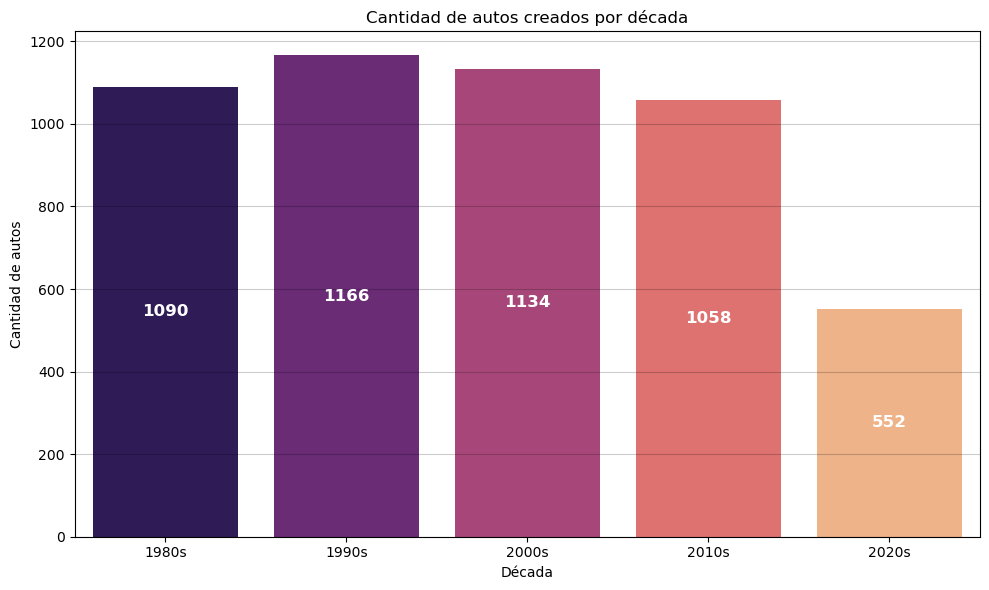

In [38]:
# Gráfico de barras con seaborn: cantidad de autos por década con valores en el centro
conteo_decadas = df['decada'].value_counts().sort_index()
plt.figure(figsize=(10,6))
bars = sns.barplot(x=conteo_decadas.index, y=conteo_decadas.values,hue=conteo_decadas.index, palette="magma", legend=False)
plt.xlabel('Década')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos creados por década')
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()

for bar, valor in zip(bars.patches, conteo_decadas.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        str(valor),
        ha='center',
        va='center',
        color='white',
        fontweight='bold',
        fontsize=12
    )

plt.show()

### Conclusión del gráfico de autos por década
Como conclusión del primer gráfico podemos ver claramente cómo los años 1990s y 2000s fueron la década donde más autos se fabricaron con respecto a las otras.

## GRAFICO II
Este grafico esta diseñado con la finalidad de saber que tipo de traccion es la mas utilizada en el mundo automovil.

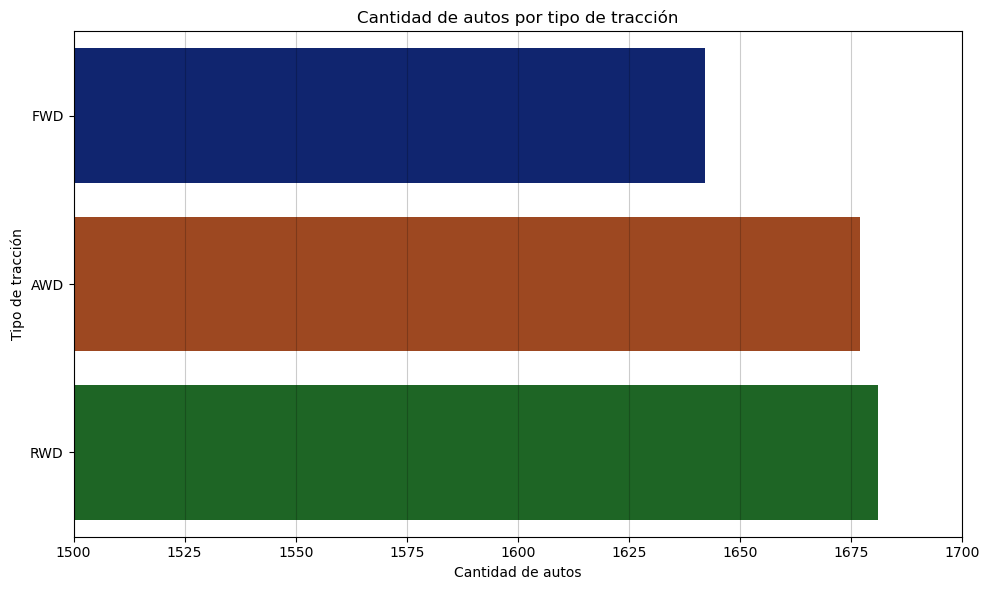

In [37]:
# Gráfico de barras horizontales con seaborn: cantidad de autos por tipo de tracción
conteo_traccion = df['Drivetrain'].value_counts().sort_values()
plt.figure(figsize=(10,6))
bars = sns.barplot(x=conteo_traccion.values, y=conteo_traccion.index,hue=conteo_traccion.values, palette="dark", legend=False)
plt.xlabel('Cantidad de autos')
plt.ylabel('Tipo de tracción')
plt.title('Cantidad de autos por tipo de tracción')
plt.xlim(1500, 1700)  # Limitar el eje X entre 1500 y 1700
plt.grid(axis='x', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de tipo de tracción
Como conclusión del gráfico podemos ver cómo la tracción más utilizada es la RWD (Traccion trasera), seguida por la AWD (Traccion en las 4 ruedas) y por último la FWD (Traccion delantera).

In [10]:
def clasificar_potencia(df):
    """
    Crea una columna 'Grupo_Potencia' con tres categorías según la columna 'Horsepower':
    - 'Potencia baja' <= 593
    - 'Potencia media' <= 1057
    - 'Potencia alta' > 1057
    """
    condiciones = [
        df['Horsepower'] <= 593,
        (df['Horsepower'] > 593) & (df['Horsepower'] <= 1057),
        df['Horsepower'] > 1057
    ]
    opciones = ['Potencia baja', 'Potencia media', 'Potencia alta']
    df['Grupo_Potencia'] = np.select(condiciones, opciones, default='Desconocido')
    return df

# Aplicar la función al DataFrame
df = clasificar_potencia(df)
display(df[['Horsepower', 'Grupo_Potencia']].head())

,Horsepower,Grupo_Potencia
0,420,Potencia baja
1,1104,Potencia alta
2,153,Potencia baja
3,544,Potencia baja
4,980,Potencia media


## GRAFICO III
Este grafico esta diseñado con la finalidad de saber la eficiencia de combustible, si fue decendiendo o aumentando a travez del tiempo.

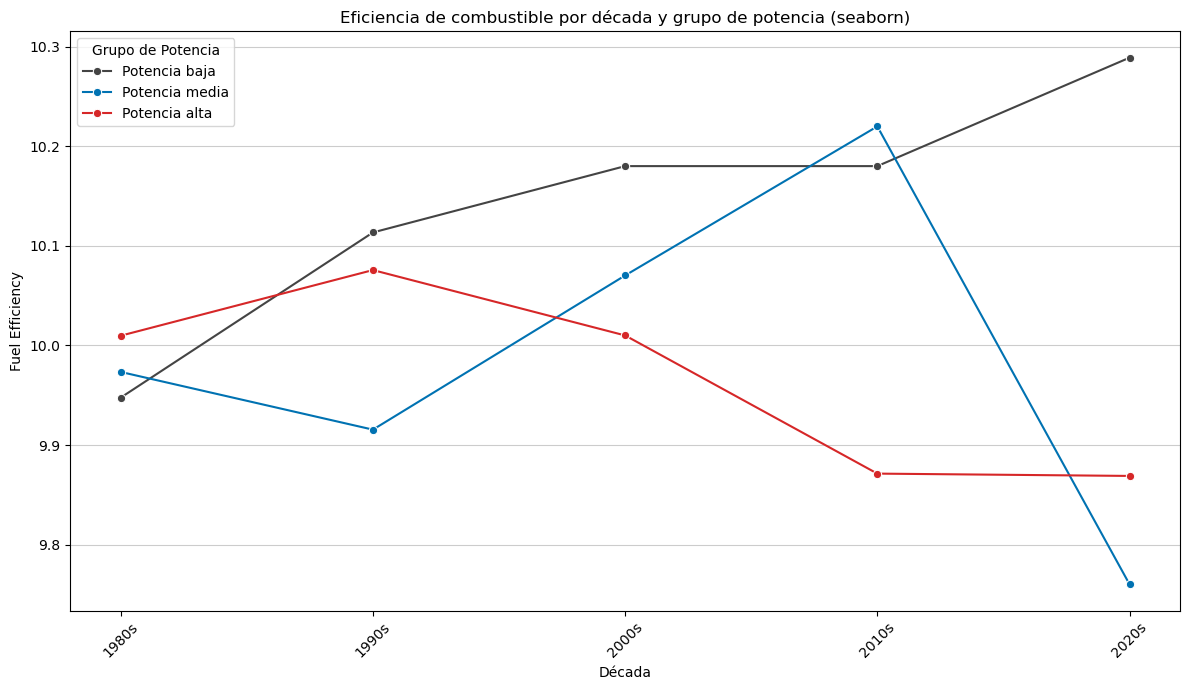

In [19]:
# Gráfico de líneas con seaborn: eficiencia de combustible por década y grupo de potencia
import seaborn as sns
plt.figure(figsize=(12,7))
grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',   # gris oscuro
    'Potencia media': '#0072B2', # azul
    'Potencia alta': '#D62728'   # rojo
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['Fuel_Efficiency'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o')
plt.xlabel('Década')
plt.ylabel('Fuel Efficiency')
plt.title('Eficiencia de combustible por década y grupo de potencia (seaborn)')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de eficiencia de combustible
Como conclusión del gráfico se puede ver cómo la eficiencia de combustible fue positiva para motores con una Potencia baja, mientras que la eficiencia para Potencia media y Alta fue decayendo a medida que pasa el tiempo.

## GRAFICO IV
Este grafico esta diseñado con la finalidad de saber la contaminacion de CO2, si fue decendiendo o aumentando a travez del tiempo.

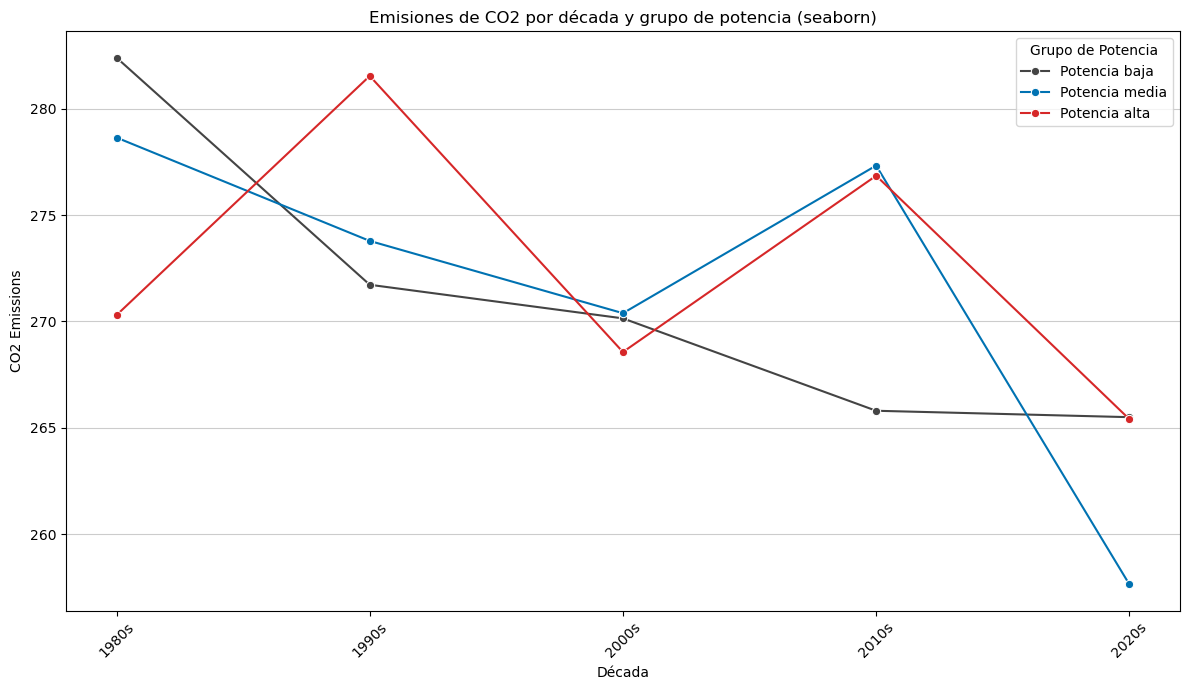

In [20]:
# Gráfico de líneas con seaborn: emisiones de CO2 por década y grupo de potencia
import seaborn as sns
plt.figure(figsize=(12,7))
grupos = ['Potencia baja', 'Potencia media', 'Potencia alta']
colores_grupo = {
    'Potencia baja': '#444444',   # gris oscuro
    'Potencia media': '#0072B2', # azul
    'Potencia alta': '#D62728'   # rojo
}
for grupo in grupos:
    datos_grupo = df[df['Grupo_Potencia'] == grupo]
    promedio = datos_grupo.groupby('decada')['CO2_Emissions'].mean().sort_index()
    sns.lineplot(x=promedio.index, y=promedio.values, label=grupo, color=colores_grupo[grupo], marker='o')
plt.xlabel('Década')
plt.ylabel('CO2 Emissions')
plt.title('Emisiones de CO2 por década y grupo de potencia (seaborn)')
plt.legend(title='Grupo de Potencia')
plt.xticks(rotation=45)
plt.grid(axis='y', color='black', alpha=0.2)
plt.tight_layout()
plt.show()

### Conclusión del gráfico de emisiones de CO2
Como se puede ver en este gráfico, los autos con motores de potencia media son los menos contaminantes actualmente, Estos tuvieron una evolución positiva a lo largo del tiempo logrando contaminar menos al ambiente. Por el contrario, los motores con una Potencia baja y alta, aunque tuvieron una bajada, son más contaminantes que el anterior, aunque siguen siendo valores relativamente bajos.